In [1]:
from bitcoin import Bitcoin
from compiler import Compiler
from ethereum import EthereumWhitepaper, EthereumByzantium
from parallel import Parallel
from sm import SelfishMining, map_params, mappable_params
import fc16sapirshtein
import seaborn as sns
import numpy as np
import pandas as pd
import tqdm
import joblib
import random
import util

In [2]:
their_mdp = Compiler(
    fc16sapirshtein.BitcoinSM(maximum_fork_length=7, **fc16sapirshtein.mappable_params)
).mdp()
their_mdp

MDP of size 120 / 4 / 646 / 5.4

In [3]:
our_mdp = Compiler(SelfishMining(Bitcoin(), maximum_height=7, **mappable_params)).mdp()
our_mdp

MDP of size 10261 / 4 / 49414 / 4.8

In [4]:
def measure(*args, model, horizon, eps, **kwargs):
    if model == "our":
        mmdp = map_params(our_mdp, **kwargs)
    else:
        mmdp = fc16sapirshtein.map_params(their_mdp, **kwargs)

    return util.optimize_and_evaluate(mmdp, horizon=horizon, eps=eps)


def jobs():
    for a in [0.2, 0.25, 0.3, 0.35]:
        for g in [0.5, 0.75]:
            for h in [100]:
                for e in [0.05, 0.025, 0.0125]:
                    common = dict(gamma=g, alpha=a, horizon=h, eps=e)
                    yield common | dict(model="our")
                    yield common | dict(model="their")


jobs = list(jobs())
jobs = random.sample(jobs, len(jobs))


def row(**kwargs):
    return kwargs | measure(**kwargs)


res_gen = joblib.Parallel(n_jobs=6, return_as="generator")(
    joblib.delayed(row)(**kwargs) for kwargs in jobs
)

rows = []
for res in tqdm.tqdm(res_gen, total=len(jobs)):
    rows.append(res)

data = pd.DataFrame(rows)

100%|███████████████████████████████████████████| 48/48 [01:22<00:00,  1.72s/it]


In [5]:
data = data.assign(rpp_minus_alpha=data.rpp - data.alpha)
data.columns

Index(['gamma', 'alpha', 'horizon', 'eps', 'model', 'vi_discount', 'vi_delta',
       'vi_stop_delta', 'vi_iter', 'vi_max_iter', 'vi_time', 'vi_max_value',
       'ss_reachable', 'ss_nonzero', 'ss_time', 'pe_iter', 'ptrev', 'rpp',
       'time', 'vi_steady_value', 'rpp_minus_alpha'],
      dtype='object')

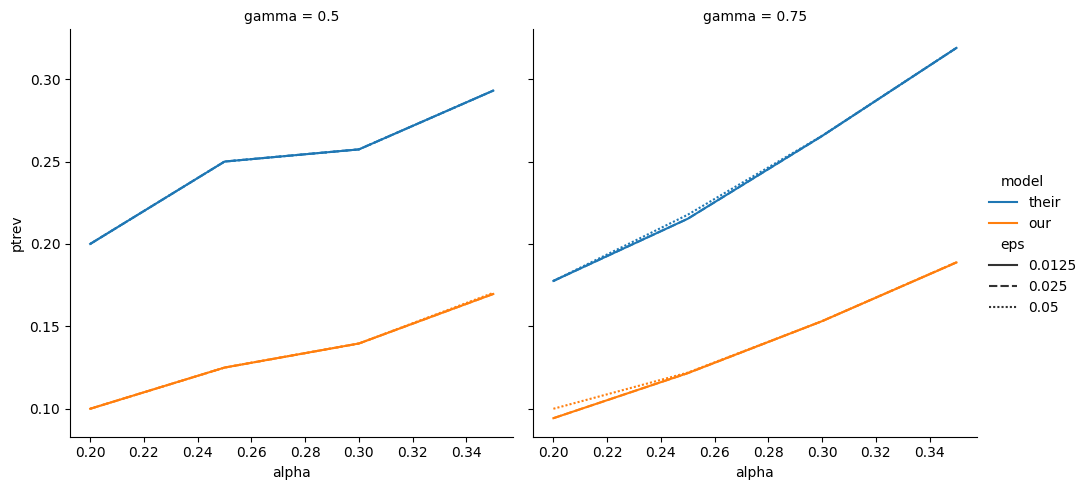

In [6]:
sns.relplot(
    data,
    kind="line",
    x="alpha",
    y="ptrev",
    hue="model",
    col="gamma",
    style="eps",
)

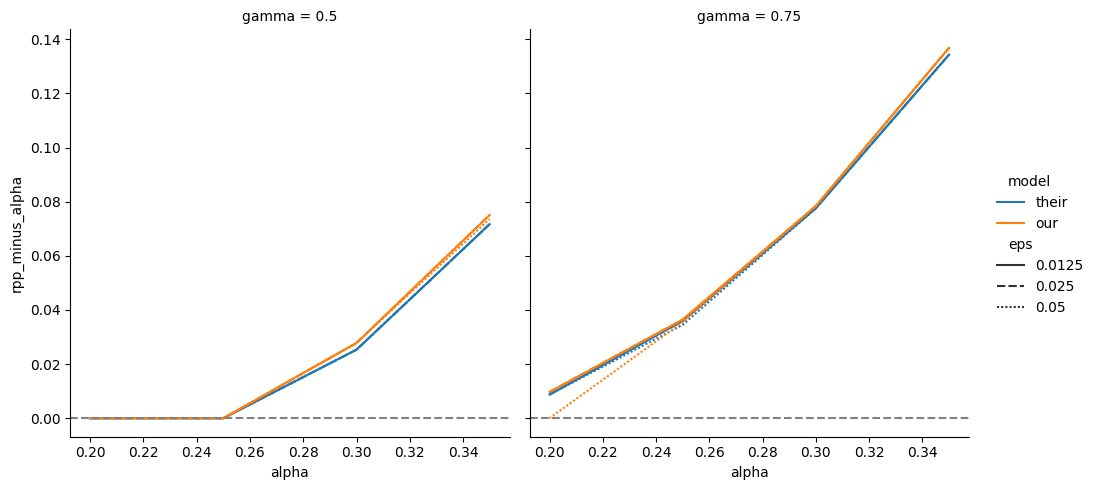

In [7]:
sns.relplot(
    data,
    kind="line",
    x="alpha",
    y="rpp_minus_alpha",
    hue="model",
    col="gamma",
    style="eps",
).refline(y=0)